##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indicices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# The Embedding layer takes at least two arguments:
# the number of possible words in the vocabulary, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 32.
embedding_layer = layers.Embedding(10000, 32)

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

As input, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

As output, the embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer, or can simply be flattened or pooled and processed by a Dense layer. We will show the latter approach in this tutorial, and you can refer to the [Text Classification with an RNN](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/text_classification_rnn.ipynb) to learn the first.

In [78]:
import pandas as pd
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

import os

path = './data/analyzed_tweets'

# os function to ('*.csv') - returns files[str]

csv_files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            csv_files.append(os.path.join(r, file))

for f in csv_files:
    print(f)
    
tweet_df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index = True)
tweet_df

./data/analyzed_tweets/polarity_joebiden_ft.csv
./data/analyzed_tweets/polarity_senwarren_ft.csv
./data/analyzed_tweets/polarity_republican_ft.csv
./data/analyzed_tweets/polarity_housegop_ft.csv
./data/analyzed_tweets/polarity_berniesanders_ft.csv
./data/analyzed_tweets/polarity_mikepence_ft.csv
./data/analyzed_tweets/polarity_marcorubio_ft.csv
./data/analyzed_tweets/polarity_tedcruz_ft.csv
./data/analyzed_tweets/polarity_donaldtrump_ft.csv
./data/analyzed_tweets/polarity_senatedemocrats_ft.csv
./data/analyzed_tweets/polarity_lizcheney_ft.csv
./data/analyzed_tweets/polarity_democrats_ft.csv
./data/analyzed_tweets/polarity_housedemocrats_ft.csv
./data/analyzed_tweets/polarity_senaterepublican_ft.csv


,Unnamed: 0,Political Affiliation,tweet,Politician,Word Count,negative,neutral,positive,polarity
0,0,Democrats,We're in a battle for the soul of this nation....,Joe Biden,46.0,0.039,0.961,0.000,-0.2023
1,1,Democrats,Today marks 50 years since the Stonewall upris...,Joe Biden,45.0,0.050,0.772,0.178,0.7650
2,2,Democrats,I’ve fought my heart out to ensure that civil ...,Joe Biden,50.0,0.043,0.860,0.097,0.4404
3,3,Democrats,"At last night’s first Democratic debate, I lai...",Joe Biden,43.0,0.000,0.845,0.155,0.6808
4,4,Democrats,"I just got off the debate stage, where I laid ...",Joe Biden,51.0,0.000,0.875,0.125,0.6486
5,5,Democrats,That’s a wrap! Thanks for following along with...,Joe Biden,32.0,0.000,0.841,0.159,0.6696
6,6,Democrats,"""There's not a single thing the American peopl...",Joe Biden,13.0,0.000,1.000,0.000,0.0000
7,7,Democrats,We know NATO will fall apart if Donald Trump i...,Joe Biden,30.0,0.000,0.912,0.088,0.4215
8,8,Democrats,Retweet if you're proud to be on #TeamJoe! #De...,Joe Biden,10.0,0.000,0.726,0.274,0.5255
9,9,Democrats,The Biden administration will make the largest...,Joe Biden,32.0,0.000,0.689,0.311,0.8807


In [126]:
import pandas_profiling
#Pandas-Profiling 2.0.0
tweet_df.profile_report()

In [129]:
profile = tweet_df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="tweet-report.html")

In [23]:
X_data = tweet_df['tweet'].copy()
X_data.head()

0    We're in a battle for the soul of this nation....
1    Today marks 50 years since the Stonewall upris...
2    I’ve fought my heart out to ensure that civil ...
3    At last night’s first Democratic debate, I lai...
4    I just got off the debate stage, where I laid ...
Name: tweet, dtype: object

In [14]:
tweet_df.columns

Index(['Unnamed: 0', 'Political Affiliation', 'tweet', 'Politician',
       'Word Count', 'negative', 'neutral', 'positive', 'polarity'],
      dtype='object')

In [22]:
# 'negative', 'neutral', 'positive'

y_data = tweet_df[['negative', 'neutral', 'positive']].copy()
y_data.head()

,negative,neutral,positive
0,0.039,0.961,0.000
1,0.050,0.772,0.178
2,0.043,0.860,0.097
3,0.000,0.845,0.155
4,0.000,0.875,0.125


In [5]:
tweet_df.groupby("Political Affiliation").mean()

,Unnamed: 0,Word Count,negative,neutral,positive,polarity
Political Affiliation,,,,,,
Democrats,2797.511487,28.970621,0.082681,0.800128,0.117191,0.100536
Republican,4179.693695,30.252752,0.076268,0.786793,0.136935,0.142881


In [7]:
tweet_df.groupby("Political Affiliation").mean().to_csv('mean_by_party')

In [6]:
tweet_df.groupby("Politician").mean()

,Unnamed: 0,Word Count,negative,neutral,positive,polarity
Politician,,,,,,
Bernie Sanders,2300.5,33.885407,0.093321,0.775067,0.131614,0.138556
Donald Trump,5651.5,32.581308,0.093439,0.741928,0.164631,0.166111
House of Democrats,3013.5,23.383590,0.065532,0.823110,0.111353,0.127218
House of Republican,712.5,23.383590,0.065532,0.823110,0.111353,0.127218
Joe Biden,807.5,23.589728,0.049892,0.816079,0.134033,0.222837
Liz Cheney,1502.5,19.310127,0.071822,0.740719,0.187462,0.249782
Marco Rubio,2980.5,36.180988,0.093087,0.798395,0.108514,0.023469
Mike Pence,4458.5,36.180988,0.093087,0.798395,0.108514,0.023469
Senate of Democrats,1183.5,30.832447,0.074471,0.831120,0.094422,0.075677


In [8]:
tweet_df.groupby("Politician").mean().to_csv('mean_by_user')

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data , y_data, random_state=42)

In [25]:
X_train.head()

30901    There is nothing we can ever give to the Democ...
33556    Thanks very much @UWyoCRs! On to victory! http...
27537    For those who continue to claim #BrowardCounty...
3938     Muslims, Latinos, &amp; LGBTQ Americans protec...
45345    Did you see the news?\n\n@GallupNews reports: ...
Name: tweet, dtype: object

In [27]:
X_train.shape

(35253,)

In [29]:
X_test.shape

(11751,)

In [28]:
y_train.shape

(35253, 3)

## Learning embeddings from scratch

We will train a sentiment classifier on tweets. In the process, we will learn embeddings from scratch. We will move quickly through the code that downloads and preprocesses the dataset (see this [tutorial](https://www.tensorflow.org/tutorials/keras/basic_text_classification) for more details).

In [33]:
import time
from tensorflow.python.keras.preprocessing.text import Tokenizer
#this must match with the embedding layer
num_words = 1000

tokenizer = Tokenizer(num_words=num_words)

# %%time

tokenizer.fit_on_texts(X_data)

In [41]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'co': 3,
 't': 4,
 'https': 5,
 'of': 6,
 'a': 7,
 'in': 8,
 'and': 9,
 'for': 10,
 'is': 11,
 'amp': 12,
 'on': 13,
 'we': 14,
 'that': 15,
 'our': 16,
 'with': 17,
 'this': 18,
 'are': 19,
 'will': 20,
 'it': 21,
 'i': 22,
 'be': 23,
 'you': 24,
 'have': 25,
 'they': 26,
 'not': 27,
 'from': 28,
 'by': 29,
 'at': 30,
 'as': 31,
 'their': 32,
 'has': 33,
 'people': 34,
 'but': 35,
 'all': 36,
 'who': 37,
 'he': 38,
 'more': 39,
 'about': 40,
 'an': 41,
 'his': 42,
 'was': 43,
 'today': 44,
 'my': 45,
 'us': 46,
 '”': 47,
 'now': 48,
 'no': 49,
 'your': 50,
 'or': 51,
 'if': 52,
 's': 53,
 'up': 54,
 'do': 55,
 'u': 56,
 'president': 57,
 'just': 58,
 'great': 59,
 'out': 60,
 'must': 61,
 'them': 62,
 'one': 63,
 '–': 64,
 'can': 65,
 'country': 66,
 'what': 67,
 'so': 68,
 'time': 69,
 'american': 70,
 'should': 71,
 'americans': 72,
 'make': 73,
 'venezuela': 74,
 'trump': 75,
 'get': 76,
 'new': 77,
 'tax': 78,
 'need': 79,
 'would': 80,
 'health': 81,
 'than'

In [54]:
word_index_dict = {
 'president': 57,
 'great': 59,
 'country': 66,
 'american': 70,
 'americans': 72,
 'make': 73,
 'venezuela': 74,
 'trump': 75,
 'tax': 78,
 'health': 81,
 'care': 84,
 'senate': 85,
 'vote': 86,
 'china': 89,
 'bill': 93,
 'families': 94,
 'democrats': 97,
 'america': 100,
 'congress': 112,
 'border': 114,
 'security': 117,
 'national': 122,
 'fight': 123,
 'republicans': 124,
 'government': 129,
 'workers': 141,
 'military': 147,
 'law': 150,
 'act': 151,
 'state': 153,
 'maduro': 155,
 'jobs': 158,
 'florida': 161,
 'economy': 164,
 'world': 166,
 'realdonaldtrump': 170,
 'family': 172,
 'news': 175,
 'companies': 180,
 'women': 183,
 'nation': 184,
 'job': 185,
 'states': 186,
 'federal': 188,
 'deal': 189,
 'rights': 193,
 'together': 194,
 'wall': 195,
 'million': 197,
 'fighting': 198,
 'biden': 204,
 'campaign': 205,
 'protect': 208,
 'demsatwork': 210,
 'strong': 211,
 'lord': 212,
 'united': 213,
 'children': 214,
 'maduroregime': 215,
 'justice': 218,
 'week': 219,
 'still': 220,
 'iran': 221,
 'judge': 222,
 'forthepeople': 223,
 'election': 227,
 'power': 231,
 'crisis': 232,
 'vp': 236,
 'txsen': 237,
 'money': 238,
 'class': 239,
 'obama': 240,
 'life': 241,
 'keeptexasred': 255,
 'administration': 265,
 'public': 266,
 'political': 268,
 'war': 272,
 'god': 273,
 'media': 274,
 'democracy': 278,
 'regime': 282,
 'kavanaugh': 284,
 'court': 285,
 'republican': 286,
 'history': 287,
 'economic': 289,
 'potus': 292,
 'report': 296,
 'future': 297,
 'leaders': 299,
 'policy': 303,
 'students': 305,
 'gop': 308,
 'reform': 310,
 'jguaido': 311,
 'free': 312,
 'trade': 316,
 'honor': 319,
 'believe': 320,
 'cuts': 321,
 'left': 322,
 'win': 324,
 'russia': 325,
 'passed': 326,
 'lives': 328,
 'cut': 329,
 'medicare': 330,
 'goptaxscam': 333,
 'access': 334,
 'insurance': 335,
 'community': 336,
 'fake': 337,
 'democratic': 339,
 'violence': 340,
 'attack': 345,
 'threat': 346,
 'climate': 357,
 'needs': 358,
 'provide': 359,
 'mexico': 360,
 'billion': 361,
 'housedemocrats': 362,
 'texas': 369,
 'action': 370,
 'love': 371,
 'record': 378,
 'sanctions': 379,
 'wage': 380,
 'hope': 381,
 'white': 382,
 'education': 383,
 'senategop': 384,
 'drug': 385,
 'taxreform': 388,
 'communities': 393,
 'freedom': 400,
 'foreign': 401,
 'washington': 402,
 'safe': 403,
 'order': 405,
 'policies': 406,
 'aid': 409,
 'press': 410,
 'wages': 411,
 'social': 415,
 'veterans': 417,
 'immigration': 423,
 'supreme': 425,
 'party': 426,
 'attacks': 427,
 'voting': 428,
 'remember': 430,
 'opportunity': 431,
 'dems': 432,
 'disaster': 433,
 'create': 434,
 'school': 437,
 'affordable': 445,
 'officials': 447,
 'paid': 448,
 'senator': 449,
 'special': 450,
 'during': 451,
 'really': 452,
 'bipartisan': 453,
 'team': 454,
 'wants': 455,
 'step': 456,
 'corporations': 457,
 'taking': 458,
 'leadership': 459,
 'legislation': 460,
 'businesses': 461,
 'funding': 462,
 'elections': 463,
 'powerful': 464,
 'taxes': 465,
 'friends': 466,
 'voted': 467,
 'around': 468,
 'office': 469,
 'shall': 470,
 'energy': 471,
 'congratulations': 472,
 'forces': 473,
 'ready': 476,
 'illegal': 479,
 'putin': 482,
 'benefits': 483,
 'sign': 484,
 'below': 485,
 'gun': 486,
 'address': 487,
 'wrong': 488,
 'behind': 489,
 'start': 490,
 'men': 491,
 'works': 492,
 'growth': 493,
 'israel': 495,
 'water': 496,
 'defend': 497,
 'county': 498,
}

In [57]:
word_index_list = word_index_dict.keys()

In [58]:
wordcloud_list = []
for word in word_index_list:
    temp_dict = {'text': (word), 'value': (tokenizer.word_counts[word])}
    wordcloud_list.append(temp_dict)

wordcloud_list    

[{'text': 'president', 'value': 2842},
 {'text': 'great', 'value': 2742},
 {'text': 'country', 'value': 2572},
 {'text': 'american', 'value': 2542},
 {'text': 'americans', 'value': 2484},
 {'text': 'make', 'value': 2436},
 {'text': 'venezuela', 'value': 2354},
 {'text': 'trump', 'value': 2310},
 {'text': 'tax', 'value': 2186},
 {'text': 'health', 'value': 2092},
 {'text': 'care', 'value': 1986},
 {'text': 'senate', 'value': 1976},
 {'text': 'vote', 'value': 1914},
 {'text': 'china', 'value': 1904},
 {'text': 'bill', 'value': 1836},
 {'text': 'families', 'value': 1830},
 {'text': 'democrats', 'value': 1734},
 {'text': 'america', 'value': 1700},
 {'text': 'congress', 'value': 1548},
 {'text': 'border', 'value': 1518},
 {'text': 'security', 'value': 1468},
 {'text': 'national', 'value': 1430},
 {'text': 'fight', 'value': 1420},
 {'text': 'republicans', 'value': 1416},
 {'text': 'government', 'value': 1374},
 {'text': 'workers', 'value': 1288},
 {'text': 'military', 'value': 1230},
 {'text

In [60]:
import json

with open('wordcloud.json', 'w') as f:  # writing JSON object
    json.dump(wordcloud_list, f)

In [70]:
some_dict = {'this': 'that'}

# with open('test.json', 'w') as f:  # writing JSON object
#     json.dump("this ="+ wordcloud_list, f)
    
with open('python_dictionary.json','w') as f:
    json.dump(some_dict, f)
with open('python_dictionary.json','r+') as f:
    dic = json.load(f)
    dic.update(wordcloud_list)
    json.dump(dic, f)

In [49]:
keys_dict = tokenizer.word_index.keys()
len(keys_dict)

38669

In [72]:
# i = 0
# for key in keys_dict
# tokenizer.word_index['compassion']

In [73]:
tokenizer.word_counts['realdonaldtrump']

1062

In [74]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)

In [75]:
#NEED TO REPLACE WITH TEST DATA (TWEETS)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [146]:
vocab_size = 10000
#imdb = keras.datasets.imdb
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

As imported, the text of reviews is integer-encoded (each integer represents a specific word in a dictionary).

In [76]:
# print(train_data[0])

### Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [85]:
# A dictionary mapping words to an integer index
word_index = tokenizer.word_index

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(X_train_tokens[0])

'there is nothing we can ever give to the democrats that will make them happy this is the highest level of presidential harassment in the history of our country'

In [86]:
decode_review(X_train_tokens[1])

'thanks very much on to victory https t co'

Movie reviews can be different lengths. We will use the `pad_sequences` function to standardize the lengths of the reviews.

In [95]:
pad = 'pre'
maxlen = 62

X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_tokens,
                                                        padding=pad,
                                                        maxlen=maxlen)

X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_tokens,
                                                       padding=pad,
                                                       maxlen=maxlen)

Let's inspect the first padded review.

In [96]:
print(X_train_pad[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  149   11  301   14   65  293  217    2    1
   97   15   20   73   62  291   18   11    1 1019  627    6  749 1641
    8    1  287    6   16   66]


### Create a simple model

We will use the [Keras Sequential API](https://www.tensorflow.org/guide/keras) to define our model.

* The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)``.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [93]:
embedding_dim=16

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    layers.GlobalAveragePooling1D(),
    layers.Dense(30, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 62, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 48        
Total params: 161,023
Trainable params: 161,023
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [97]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

W0630 19:44:16.367097 4470719936 deprecation.py:323] From /anaconda3/envs/TestEnv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 1s 21us/sample - loss: 0.6304 - accuracy: 0.2905 - val_loss: 0.5320 - val_accuracy: 0.2940
Epoch 2/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.4528 - accuracy: 0.2909 - val_loss: 0.4025 - val_accuracy: 0.2940
Epoch 3/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3927 - accuracy: 0.2909 - val_loss: 0.3873 - val_accuracy: 0.2940
Epoch 4/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3877 - accuracy: 0.2909 - val_loss: 0.3858 - val_accuracy: 0.2940
Epoch 5/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3861 - accuracy: 0.2909 - val_loss: 0.3843 - val_accuracy: 0.2940
Epoch 6/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3843 - accuracy: 0.2909 - val_loss: 0.3825 - val_accuracy: 0.2940
Epoch 7/30
28202/28202 [==============================] - 0s 8

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

In [98]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3293 - accuracy: 0.2909 - val_loss: 0.3321 - val_accuracy: 0.2940
Epoch 2/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3289 - accuracy: 0.2909 - val_loss: 0.3320 - val_accuracy: 0.2940
Epoch 3/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3284 - accuracy: 0.2909 - val_loss: 0.3314 - val_accuracy: 0.2940
Epoch 4/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3280 - accuracy: 0.2909 - val_loss: 0.3312 - val_accuracy: 0.2940
Epoch 5/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3277 - accuracy: 0.2909 - val_loss: 0.3308 - val_accuracy: 0.2940
Epoch 6/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.3273 - accuracy: 0.2909 - val_loss: 0.3305 - val_accuracy: 0.2940
Epoch 7/30
28202/28202 [==============================] - 0s 7u

# Changing first model to catagorical crossentrepy

In [147]:
embedding_dim=16

model_1 = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    layers.GlobalAveragePooling1D(),
    layers.Dense(30, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 161,023
Trainable params: 161,023
Non-trainable params: 0
_________________________________________________________________


In [148]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_1.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 1s 21us/sample - loss: 1.0447 - accuracy: 0.9660 - val_loss: 0.9510 - val_accuracy: 0.9841
Epoch 2/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.8002 - accuracy: 0.9837 - val_loss: 0.6572 - val_accuracy: 0.9841
Epoch 3/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.6487 - accuracy: 0.9837 - val_loss: 0.6441 - val_accuracy: 0.9841
Epoch 4/30
28202/28202 [==============================] - 0s 9us/sample - loss: 0.6450 - accuracy: 0.9837 - val_loss: 0.6416 - val_accuracy: 0.9841
Epoch 5/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.6420 - accuracy: 0.9837 - val_loss: 0.6384 - val_accuracy: 0.9841
Epoch 6/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.6374 - accuracy: 0.9837 - val_loss: 0.6324 - val_accuracy: 0.9841
Epoch 7/30
28202/28202 [==============================] - 0s 9

In [ ]:
model.

In [138]:
history_1 = model_1.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 0s 9us/sample - loss: 0.5222 - accuracy: 0.9922 - val_loss: 0.5302 - val_accuracy: 0.9911
Epoch 2/30
28202/28202 [==============================] - 0s 9us/sample - loss: 0.5214 - accuracy: 0.9923 - val_loss: 0.5292 - val_accuracy: 0.9915
Epoch 3/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.5206 - accuracy: 0.9927 - val_loss: 0.5289 - val_accuracy: 0.9913
Epoch 4/30
28202/28202 [==============================] - 0s 8us/sample - loss: 0.5199 - accuracy: 0.9928 - val_loss: 0.5285 - val_accuracy: 0.9915
Epoch 5/30
28202/28202 [==============================] - 0s 9us/sample - loss: 0.5194 - accuracy: 0.9928 - val_loss: 0.5281 - val_accuracy: 0.9916
Epoch 6/30
28202/28202 [==============================] - 0s 9us/sample - loss: 0.5195 - accuracy: 0.9927 - val_loss: 0.5279 - val_accuracy: 0.9919
Epoch 7/30
28202/28202 [==============================] - 0s 9u

In [110]:
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential

In [111]:

model_2 = Sequential()

embedding_size = 8

model_2.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=maxlen,
                    name='layer_embedding'))

model_2.add(GRU(units=24, return_sequences=True))

model_2.add(GRU(units=12, return_sequences=True))

model_2.add(GRU(units=6))

model_2.add(Dense(3, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model_2.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [112]:
history = model_2.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

/anaconda3/envs/TestEnv/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 15s 532us/sample - loss: 0.5499 - accuracy: 0.2871 - val_loss: 0.4126 - val_accuracy: 0.2940
Epoch 2/30
28202/28202 [==============================] - 10s 359us/sample - loss: 0.4009 - accuracy: 0.2909 - val_loss: 0.3947 - val_accuracy: 0.2940
Epoch 3/30
28202/28202 [==============================] - 10s 360us/sample - loss: 0.3941 - accuracy: 0.2909 - val_loss: 0.3915 - val_accuracy: 0.2940
Epoch 4/30
28202/28202 [==============================] - 10s 361us/sample - loss: 0.3921 - accuracy: 0.2909 - val_loss: 0.3903 - val_accuracy: 0.2940
Epoch 5/30
28202/28202 [==============================] - 10s 367us/sample - loss: 0.3913 - accuracy: 0.2909 - val_loss: 0.3898 - val_accuracy: 0.2940
Epoch 6/30
28202/28202 [==============================] - 11s 385us/sample - loss: 0.3911 - accuracy: 0.2909 - val_loss: 0.3896 - val_accuracy: 0.2940
Epoch 7/30
28202/28202 [=====================

In [115]:
model_3 = Sequential()

embedding_size = 8

model_3.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=maxlen,
                    name='layer_embedding'))

model_3.add(GRU(units=24, return_sequences=True))

model_3.add(GRU(units=12, return_sequences=True))

model_3.add(GRU(units=6))

model_3.add(Dense(3, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [116]:
# vocab_size
history_3 = model_3.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

Train on 28202 samples, validate on 7051 samples
Epoch 1/30
28202/28202 [==============================] - 15s 533us/sample - loss: 0.9347 - accuracy: 0.9709 - val_loss: 0.7452 - val_accuracy: 0.9841
Epoch 2/30
28202/28202 [==============================] - 10s 362us/sample - loss: 0.6936 - accuracy: 0.9837 - val_loss: 0.6614 - val_accuracy: 0.9841
Epoch 3/30
28202/28202 [==============================] - 10s 361us/sample - loss: 0.6563 - accuracy: 0.9837 - val_loss: 0.6497 - val_accuracy: 0.9841
Epoch 4/30
28202/28202 [==============================] - 10s 364us/sample - loss: 0.6507 - accuracy: 0.9837 - val_loss: 0.6474 - val_accuracy: 0.9841
Epoch 5/30
28202/28202 [==============================] - 10s 368us/sample - loss: 0.6491 - accuracy: 0.9837 - val_loss: 0.6458 - val_accuracy: 0.9841
Epoch 6/30
28202/28202 [==============================] - 11s 383us/sample - loss: 0.6451 - accuracy: 0.9837 - val_loss: 0.6361 - val_accuracy: 0.9848
Epoch 7/30
28202/28202 [=====================

In [118]:
%%time
result = model_3.evaluate(X_test_pad, y_test)

11751/11751 [==============================] - 21s 2ms/sample - loss: 0.5404 - accuracy: 0.9916
CPU times: user 24.2 s, sys: 2.87 s, total: 27.1 s
Wall time: 21.4 s


In [119]:
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

In [120]:
tokens = tokenizer.texts_to_sequences(texts)

In [121]:
tokens_pad = keras.preprocessing.sequence.pad_sequences(X_train_tokens,
                                                        padding=pad,
                                                        maxlen=maxlen)
tokens_pad.shape

(35253, 62)

In [134]:
predict_list = model_3.predict(tokens_pad)
print(predict_list)

[[0.25057903 0.8326596  0.24123198]
 [0.01328379 0.63284326 0.37106073]
 [0.01761818 0.8553448  0.0087423 ]
 ...
 [0.17709902 0.84792507 0.23083875]
 [0.01745576 0.85300297 0.00937634]
 [0.01324702 0.7756018  0.08863922]]


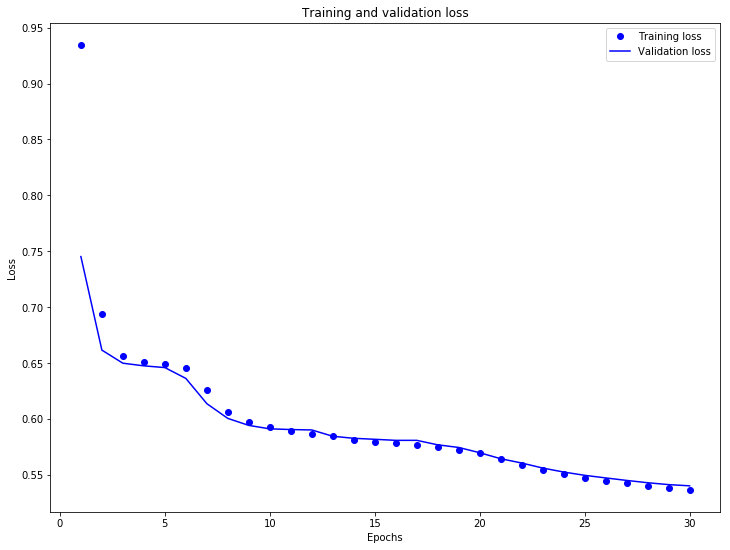

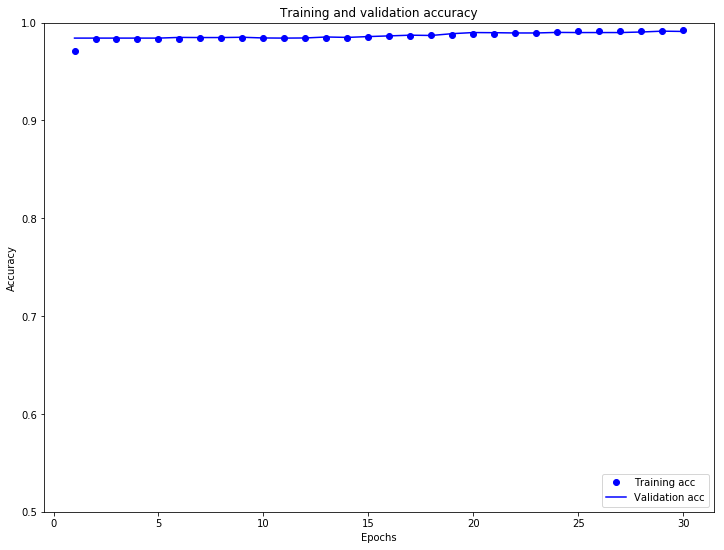

In [117]:
import matplotlib.pyplot as plt

history_dict = history_3.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show();

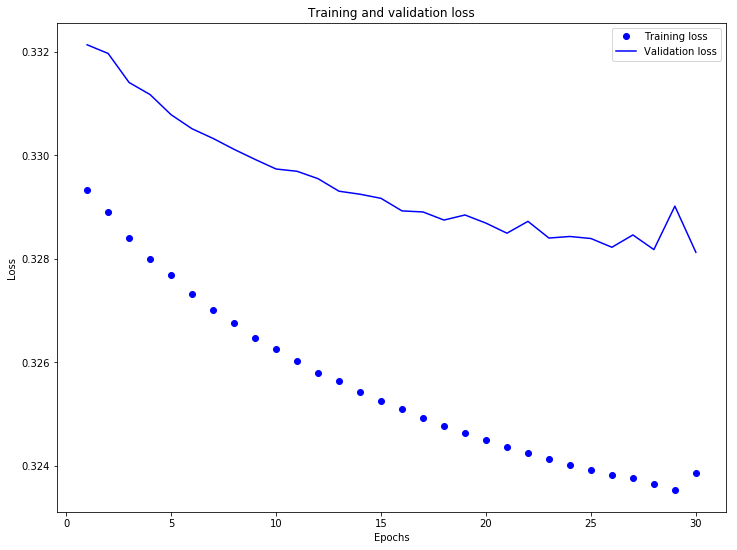

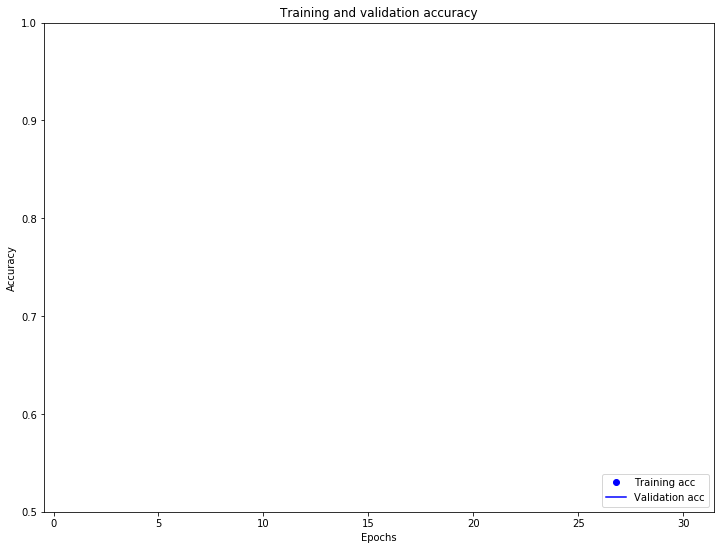

In [100]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show();

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size,embedding-dimension)`.

In [141]:
vocab_size

10000

In [139]:
e = model_1.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [142]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(vocab_size):
for word_num in range(vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

KeyError: 0

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [13]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/).

* Click on "Load data".

* Upload the two files we created above: ```vecs.tsv``` and ```meta.tsv```. T

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn more about embeddings in Keras we recommend these [notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Chollet.

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).